In [1]:
!ps -A -o %cpu | awk '{s+=$1} END {print s "%"}'

58.9%


In [2]:
N_JOBS = 3
LOW_MEMORY_MODE = True
ALLOW_FEATURE_SELECTION = False

### Описание датасета

https://docs.google.com/document/d/1UaZT_DzEINcF04E7LpvrlyHYemVTqjvjYKKgxCS0SwI/edit

### Контест на kaggle

https://www.kaggle.com/c/ml-mipt-spring2018-1

___

In [1]:
from collections import Counter, defaultdict
from copy import deepcopy
from operator import itemgetter
from random import shuffle

import numpy as np
import pandas as pd
import scipy
import seaborn as sns
from matplotlib import pylab, gridspec, pyplot as plt
from IPython.display import Image
import urllib


from sklearn.metrics import accuracy_score
from sklearn import metrics, neighbors, dummy, preprocessing, svm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import OneHotEncoder

import matplotlib
%matplotlib inline

In [2]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import gc


# О данных
___
### Macro

`xray` - файл получен рентгеновской кристаллографией или нет

`resol` - разрешение структуры

`chainlen` - длина цепи РНК

`protein` - присутствует ли в файле белок

`moiety` - фрагмент нуклеотида (принимает значения 1/2/3, т.е. P/B/R)


___

### Other

Торсионные углы данного нуклеотида + по 2 соседних нуклеотида вверх и вниз по цепи:
`alpha, beta, gamma, delta, epsilon, zeta, e-z, chi, phase-angle, sszp, dp, splay, eta, theta, etap, thetap, etapp, thetapp, v0, v1, v2, v3, v4, tm, p`)
для соседних нуклеотидов к именам добавляется 1/m1/2/m2 (m = minus) = 125

`seqA, seqC, seqG, seqU`: название нуклеотида + по 2 соседних нуклеотида вверх и вниз по цепи. Для соседних нуклеотидов к именам добавляется 1/m1/2/m2 (m = minus) = 20

`SI, SII, SIII, ..., SXXIX, cWH, cWS, cWW, cHS, cHH, cSS, tWH, tWS, tWW, tHS, tHH, tSS`: спаривания (по классам) (+соседи). Каждый признак = число спариваний данного типа, в которых участвует данный нуклеотид; присутствуют типы спариваний в двух классификациях – по Сэнгеру (SI,…, SXXIX) и по Леонтису (сWH…, tSS); для соседних нуклеотидов к именам добавляется 1/m1/2/m2 (m = minus) = 205
	
stem = 0/1
тип петли (`hairpin, bulge, internal, junction = 0/1`)
длина нити/крыла (wtlen)
номер нуклеотида в нити/крыле (минимальный из двух нумераций, wtnum)


# что можно сделать

Поизучать данные (баланс выборки, корреляция параметров, графички построить, ... см pdf-ки)

feature selection

нормировка параметров

отбор параметров

поиск по сетке для xgboost

сбалансировать выборку



# Загрузка данных

In [6]:
test_data = pd.read_csv('test.csv')
train_data = pd.read_csv('train.csv', sep='\t')
train_data.head()

,pdb_chain,DSSR,xray,resol,chainlen,protein,alpham2,betam2,gammam2,deltam2,...,atomO2p,atomO3p,atomO4,atomO4p,atomO5p,atomO6,atomOP1,atomOP2,atomOP3,mg
0,1b23.cif1_R,R.G.1.,1,2.6,74,1,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,1,0
1,1b23.cif1_R,R.G.1.,1,2.6,74,1,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,1,0,0,0
2,1b23.cif1_R,R.G.1.,1,2.6,74,1,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,1,0,0
3,1b23.cif1_R,R.G.1.,1,2.6,74,1,NaN,NaN,NaN,NaN,...,0,0,0,0,1,0,0,0,0,0
4,1b23.cif1_R,R.G.1.,1,2.6,74,1,NaN,NaN,NaN,NaN,...,0,0,0,1,0,0,0,0,0,0


In [16]:
train_data.sample(5)

,pdb_chain,DSSR,xray,resol,chainlen,protein,alpham2,betam2,gammam2,deltam2,...,atomO2p,atomO3p,atomO4,atomO4p,atomO5p,atomO6,atomOP1,atomOP2,atomOP3,mg
103266,3ski.cif1_A,A.C.39.,1,2.30,68,0,-63.7,163.3,61.9,81.9,...,0,0,0,1,0,0,0,0,0,0
112906,4gxy.cif1_A,A.G.78.,1,3.05,172,0,155.3,179.7,177.8,83.2,...,0,0,0,0,1,0,0,0,0,0
219823,5t5h.cif1_E,E.A.7.,0,2.54,146,1,-6.5,143.5,24.9,80.1,...,0,1,0,0,0,0,0,0,0,0
39484,2qbz.cif1_X,X.C.96.,1,2.60,161,0,-46.3,166.9,42.0,79.2,...,0,0,0,0,0,0,0,0,0,0
11235,1l2x.cif1_A,A.C.22.,1,1.25,28,0,64.6,-169.6,-172.7,83.3,...,0,1,0,0,0,0,0,0,0,0


# Изучение данных и обработка

In [7]:
def EDS(ds):
    l = len(ds)
    print('---- соотношения классов ----')
    counts_norm = ds.value_counts(normalize=True)
    counts = ds.value_counts()
    if (len(counts) < 10):
        print(pd.DataFrame({'cnt': counts, 'percent':counts_norm}))
    else:
        print(pd.DataFrame({'cnt': counts[:7], 'percent':counts_norm[:7]}))
        print('...')
        print(pd.DataFrame({'cnt': counts[-7:], 'percent':counts_norm[-7:]}))
    print('Total:', len(counts))
    
    print()
    
    print('---- NA count ----')
    print('NA''s:', ds.isnull().sum() / l)
    
    ds.hist(bins=25, figsize=(15,3))
    pass

---- соотношения классов ----
                cnt   percent
5aj3.cif1_A   10289  0.043237
3j9m.cif1_AA   9893  0.041573
5t5h.cif1_B    9820  0.041266
4r0d.cif1_A    6676  0.028054
3g78.cif1_A    4241  0.017822
3q1q.cif1_B    3754  0.015775
1y0q.cif1_A    2471  0.010384
...
             cnt   percent
1xmq.cif1_W   42  0.000176
1xnq.cif1_W   42  0.000176
1xnr.cif1_W   41  0.000172
2f4v.cif1_Z   40  0.000168
1n33.cif1_Z   38  0.000160
1ibl.cif1_Z   38  0.000160
1n32.cif1_Z   38  0.000160
Total: 338

---- NA count ----
NAs: 0.0


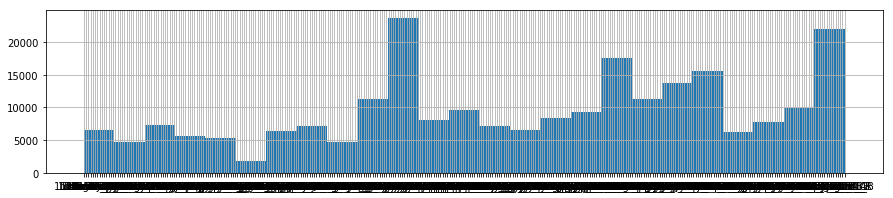

In [8]:
EDS(train_data['pdb_chain'])

In [8]:
# EDS(train_data['DSSR'])

In [6]:
86/13

6.615384615384615

---- соотношения классов ----
      cnt   percent
0  206972  0.869744
1   30997  0.130256
Total: 2

---- NA count ----
NAs: 0.0


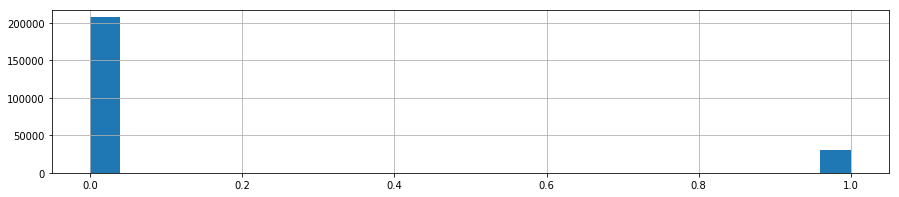

In [7]:
EDS(train_data['mg'])

### Матрица корреляций

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 10 µs


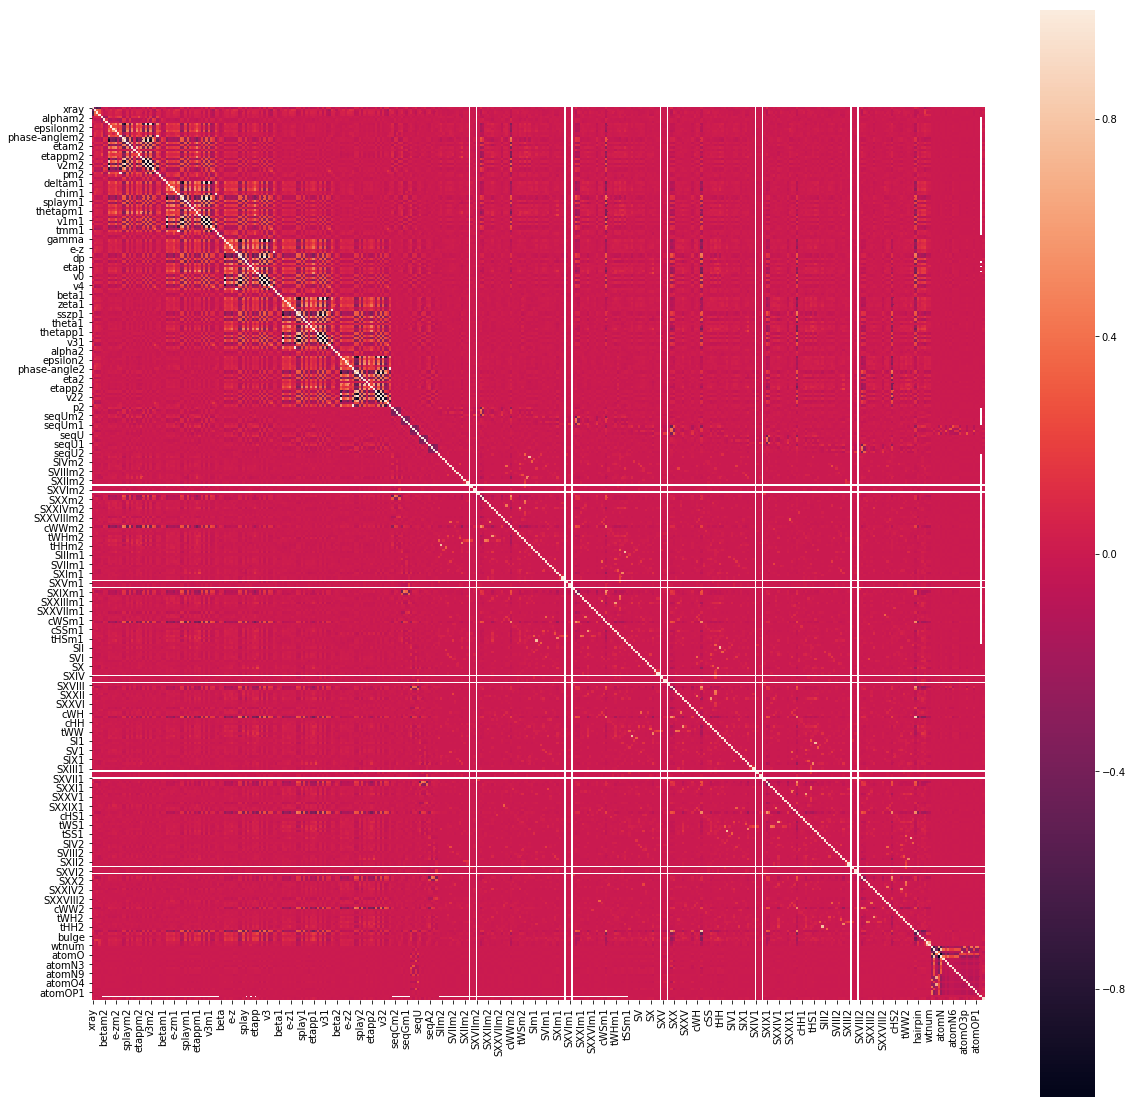

In [9]:
%time
plt.figure(figsize=(20, 20))
corr_matrix = train_data.corr()
sns.heatmap(corr_matrix, square=True)
plt.show()

In [10]:
def get_collinear_columns(df, threshold):
    goodlist = list(df[df > threshold].stack().index)
    ans = set()
    setleft = set()
    goodlist = set(goodlist)
    while len(goodlist) > 0:
        t = goodlist.pop()
        
        goodlist = set([x for x in set(goodlist) if x[1] != t[1]])
        goodlist = set([x for x in set(goodlist) if x[0] != t[1]])
        
        ans.add(t[1])
    return ans

In [11]:
corr_matrix.fillna(0, inplace=True)
corr_matrix -= np.eye(corr_matrix.shape[0])
corr_matrix = np.abs(corr_matrix)

In [12]:
max_corr_level = 0.85
deleted = list(get_collinear_columns(corr_matrix, max_corr_level))
print('with corr level {} can kill {} columns:\n {}'.format(max_corr_level,
        len(deleted), deleted))

train_data_dc = train_data.drop(deleted, axis=1)

with corr level 0.85 can kill 41 columns:
 ['delta2', 'v2m1', 'delta1', 'phase-angle1', 'v4m1', 'dpm1', 'v3m1', 'SXIV', 'SXVIIm1', 'SXIVm2', 'v21', 'v1m1', 'v12', 'v32', 'v11', 'v4m2', 'v1', 'SXVIIm2', 'v31', 'v0', 'delta', 'v02', 'SXIVm1', 'dp2', 'SXVII', 'v1m2', 'SXIV2', 'SXIV1', 'atomO', 'v2m2', 'v3', 'SXVII1', 'phase-anglem1', 'SXVII2', 'v2', 'phase-anglem2', 'dpm2', 'p', 'v4', 'deltam2', 'phase-angle2']


In [13]:
test_data.drop(['Id', 'index'], axis=1, inplace=True)
test_data.drop(deleted, axis=1, inplace=True)

In [17]:
train_data_dc.shape, test_data.shape

((237969, 345), (4045, 344))

In [18]:
accuracy_score(test_data.columns, train_data_dc.drop(['mg'], axis=1).columns)

1.0

In [19]:
list(train_data.columns)

['pdb_chain',
 'DSSR',
 'xray',
 'resol',
 'chainlen',
 'protein',
 'alpham2',
 'betam2',
 'gammam2',
 'deltam2',
 'epsilonm2',
 'zetam2',
 'e-zm2',
 'chim2',
 'phase-anglem2',
 'sszpm2',
 'dpm2',
 'splaym2',
 'etam2',
 'thetam2',
 'etapm2',
 'thetapm2',
 'etappm2',
 'thetappm2',
 'v0m2',
 'v1m2',
 'v2m2',
 'v3m2',
 'v4m2',
 'tmm2',
 'pm2',
 'alpham1',
 'betam1',
 'gammam1',
 'deltam1',
 'epsilonm1',
 'zetam1',
 'e-zm1',
 'chim1',
 'phase-anglem1',
 'sszpm1',
 'dpm1',
 'splaym1',
 'etam1',
 'thetam1',
 'etapm1',
 'thetapm1',
 'etappm1',
 'thetappm1',
 'v0m1',
 'v1m1',
 'v2m1',
 'v3m1',
 'v4m1',
 'tmm1',
 'pm1',
 'alpha',
 'beta',
 'gamma',
 'delta',
 'epsilon',
 'zeta',
 'e-z',
 'chi',
 'phase-angle',
 'sszp',
 'dp',
 'splay',
 'eta',
 'theta',
 'etap',
 'thetap',
 'etapp',
 'thetapp',
 'v0',
 'v1',
 'v2',
 'v3',
 'v4',
 'tm',
 'p',
 'alpha1',
 'beta1',
 'gamma1',
 'delta1',
 'epsilon1',
 'zeta1',
 'e-z1',
 'chi1',
 'phase-angle1',
 'sszp1',
 'dp1',
 'splay1',
 'eta1',
 'theta1',
 'eta

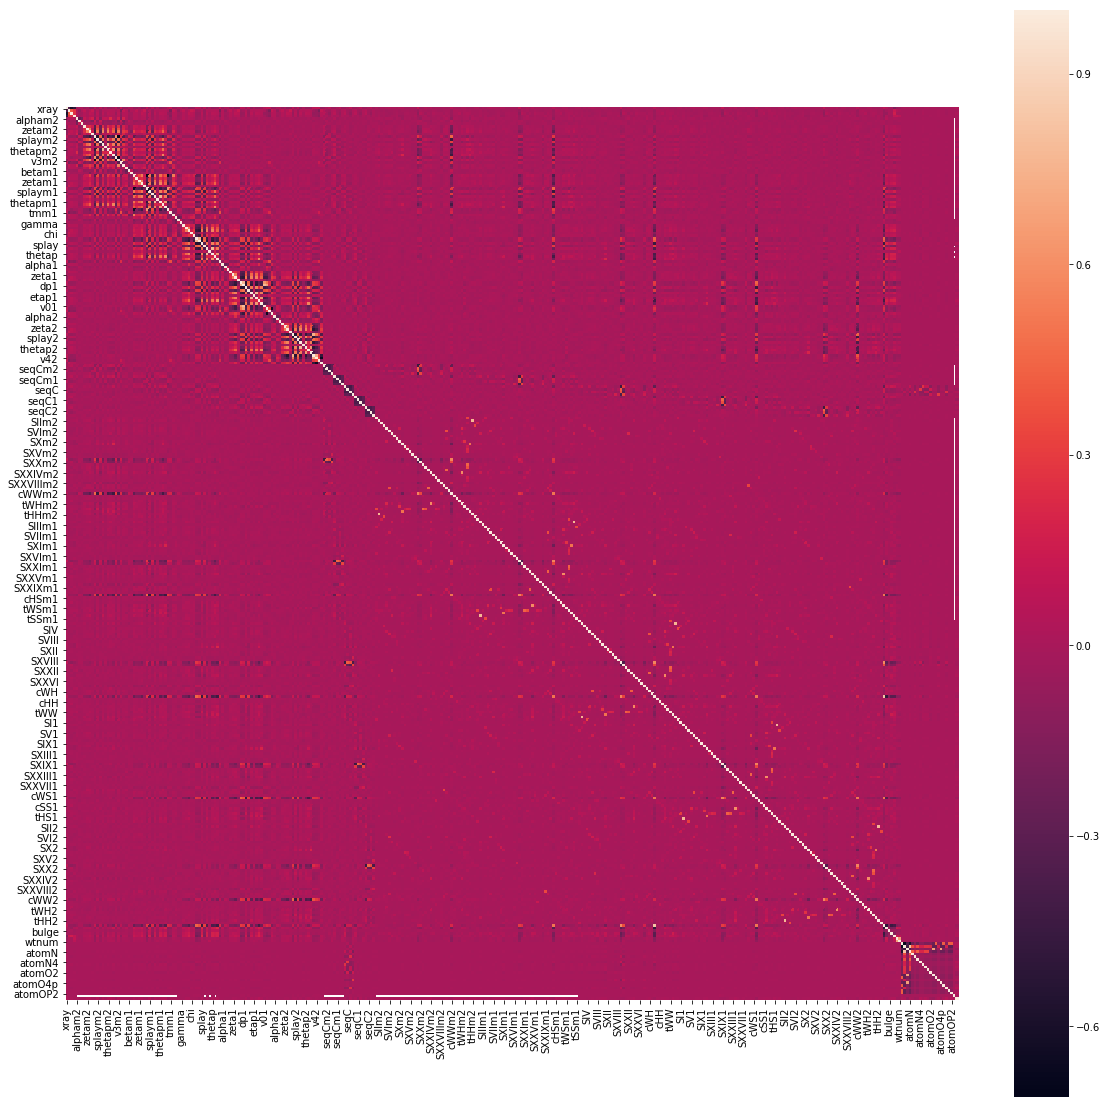

In [20]:
plt.figure(figsize=(20, 20))
new_corr_matrix = train_data_dc.corr()
sns.heatmap(new_corr_matrix, square=True)
plt.show()

### feature selection

**Посчитанные варианты (для Random Forest Regressor)**


``118 120 121 123 129 130 131 137 141 142 159 160 168 169 170 176 179 180
 181 198 199 207 208 209 218 219 220 235 237 238 239 240 243 246 247 248
 250 253 258 261 274 276 285 286 287 292 297 300 305 340``

 **Еще один вариант:**
 
 ``123 125 126 128 134 135 136 142 146 147 164 165 167 173 174 175 181 184
 185 186 203 204 205 212 213 214 220 223 224 225 240 242 243 245 248 251
 252 253 258 263 266 279 281 283 290 291 292 294 302 310``

#### Tree-based

In [22]:
%%time
to_delete = []
if ALLOW_FEATURE_SELECTION:
    clf_feature_imp = RandomForestRegressor(n_jobs=N_JOBS, n_estimators=10)
    clf_feature_imp = clf_feature_imp.fit(train_data_dc.drop(
    ['mg', 'DSSR', 'pdb_chain'], axis=1).fillna(0.0), train_data_dc['mg'])
    
    plt.figure(figsize=(12, 8))
    plt.plot(sorted(list(clf_feature_imp.feature_importances_)))
    plt.grid()
    plt.show()
    
    importance_threshold = sorted(list(clf_feature_imp.feature_importances_))[50]
    print('threshold:', importance_threshold)
    
    to_delete = np.argwhere(clf_feature_imp.feature_importances_ < importance_threshold).ravel()
    print(to_delete)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 16 µs


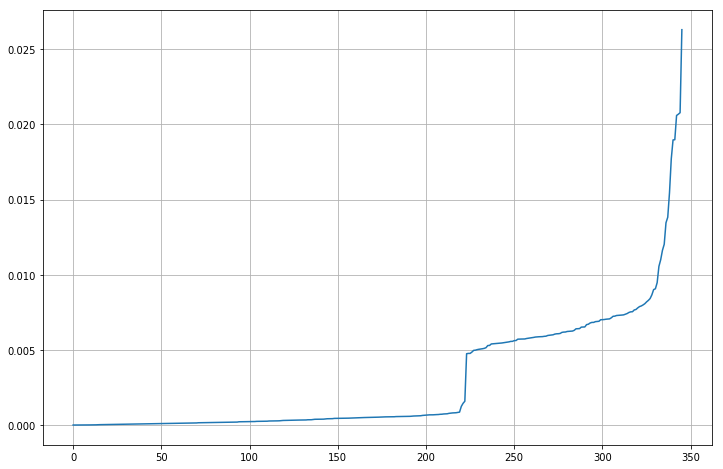

In [23]:
train_data_dc_du = train_data_dc.drop(train_data_dc.drop(
    ['mg', 'DSSR', 'pdb_chain'], axis=1).columns[to_delete], axis=1)
train_data_dc_du.shape

(237969, 345)

In [24]:
test_data_dc_du = test_data.drop(test_data.drop(
    ['DSSR', 'pdb_chain'], axis=1).columns[to_delete], axis=1)
test_data_dc_du.shape

(4045, 344)

In [25]:
train_data_dc_du.fillna(0.0, inplace=True)

In [26]:
test_data_dc_du.fillna(0.0, inplace=True)

#### One-hot encoding `pdb_chain`

In [34]:
train_data_dc_du.sample(5)

,pdb_chain,DSSR,xray,resol,chainlen,protein,alpham2,betam2,gammam2,epsilonm2,...,atomO2p,atomO3p,atomO4,atomO4p,atomO5p,atomO6,atomOP1,atomOP2,atomOP3,mg
74678,3j9m.cif1_AA,AA.G.1031.,0,3.500000,954,1,-73.7,-175.6,58.2,-153.6,...,1,0,0,0,0,0,0,0,0,0
141858,4r0d.cif1_A,A.U.386.,1,3.676000,622,0,-55.1,163.4,51.1,-147.8,...,0,0,0,0,0,0,0,1,0,0
237719,5une.cif1_B,B.C.47.,1,2.900099,47,0,-67.5,170.5,52.4,-150.9,...,0,0,0,0,0,0,0,1,0,0
106524,3v7e.cif1_C,C.U.17.,1,2.800000,126,1,123.5,-80.1,-173.2,-126.3,...,0,0,0,0,1,0,0,0,0,1
140296,4r0d.cif1_A,A.G.241.,1,3.676000,622,0,-82.4,121.1,98.2,-145.2,...,0,0,0,0,0,0,0,0,0,1


In [27]:
from sklearn.feature_extraction import DictVectorizer

In [33]:
def number_encode_features(init_df):
    result = init_df.copy()
    encoders = {}
    for column in result.columns:
        if result.dtypes[column] == np.object:
            encoders[column] = preprocessing.LabelEncoder()
            result[column] = encoders[column].fit_transform(result[column])
    return result, encoders

In [40]:
train_data_dc_du = train_data_dc_du.merge(train_data_dc_du.DSSR.apply(lambda s: pd.Series({'DSSR1':s.split('.')[0], 'DSSR2':s.split('.')[1], 'DSSR3':int(s.split('.')[2])})), 
    left_index=True, right_index=True)
test_data_dc_du = test_data_dc_du.merge (test_data_dc_du.DSSR.apply(lambda s: pd.Series({'DSSR1':s.split('.')[0], 'DSSR2':s.split('.')[1], 'DSSR3':int(s.split('.')[2])})), 
    left_index=True, right_index=True)

In [42]:
train_data_dc_du.drop(['DSSR'], axis=1, inplace=True)
test_data_dc_du.drop(['DSSR'], axis=1, inplace=True)

In [45]:
train_data_dc_du.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237969 entries, 0 to 237968
Data columns (total 347 columns):
pdb_chain      object
xray           int64
resol          float64
chainlen       int64
protein        int64
alpham2        float64
betam2         float64
gammam2        float64
epsilonm2      float64
zetam2         float64
e-zm2          float64
chim2          float64
sszpm2         float64
splaym2        float64
etam2          float64
thetam2        float64
etapm2         float64
thetapm2       float64
etappm2        float64
thetappm2      float64
v0m2           float64
v3m2           float64
tmm2           float64
pm2            float64
alpham1        float64
betam1         float64
gammam1        float64
deltam1        float64
epsilonm1      float64
zetam1         float64
e-zm1          float64
chim1          float64
sszpm1         float64
splaym1        float64
etam1          float64
thetam1        float64
etapm1         float64
thetapm1       float64
etappm1        float6

In [46]:
train_data_dc_du, trainenc = number_encode_features(train_data_dc_du)
test_data_dc_du, testenc = number_encode_features(test_data_dc_du)

AttributeError: 'tuple' object has no attribute 'sample'

In [51]:
train_data_dc_du.sample(10)

,pdb_chain,xray,resol,chainlen,protein,alpham2,betam2,gammam2,epsilonm2,zetam2,...,atomO4p,atomO5p,atomO6,atomOP1,atomOP2,atomOP3,mg,DSSR1,DSSR2,DSSR3
122064,211,1,3.200,75,1,148.8,-171.1,176.4,-92.5,-105.3,...,0,0,0,1,0,0,0,27,0,74
128558,220,1,2.500,192,0,-31.9,-144.4,131.0,-166.2,106.3,...,0,0,0,0,0,0,1,10,1,313
2422,6,1,2.300,72,1,-66.4,-173.5,54.8,-161.1,-64.5,...,0,0,0,0,0,0,0,18,1,104
145751,236,1,2.000,19,1,-60.7,174.0,51.3,-153.1,-74.1,...,0,0,0,0,0,0,0,21,0,14
63753,138,1,2.987,137,1,-59.3,166.3,54.7,-135.0,-70.5,...,0,0,0,1,0,0,1,21,3,76
213556,322,0,3.200,121,1,-117.0,109.1,136.8,-95.7,-95.7,...,0,0,0,0,0,0,0,18,3,4
29705,67,1,2.950,14,0,-71.8,-175.4,55.2,-169.2,-62.5,...,0,0,0,1,0,0,0,18,1,34
30647,75,1,2.300,23,0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,10,2,3
67549,142,0,3.200,119,1,87.0,-141.0,-126.8,-145.4,-64.9,...,1,0,0,0,0,0,0,18,2,99
129633,221,1,1.900,35,0,-83.5,-134.4,49.2,-161.9,-60.7,...,1,0,0,0,0,0,1,10,1,30


In [52]:
# encoded_data_test, encoders_test = number_encode_features(test_data_dc_du)
# encoded_data_test.sample(10)

In [57]:
enc = OneHotEncoder()
enc.fit(train_data_dc_du[['pdb_chain', 'DSSR1', 'DSSR2']])

OneHotEncoder(categorical_features='all', dtype=<class 'numpy.float64'>,
       handle_unknown='error', n_values='auto', sparse=True)

In [58]:
encodedstr = pd.DataFrame(enc.transform(train_data_dc_du[['pdb_chain', 'DSSR1', 'DSSR2']]).todense())

In [59]:
encodedstr_test = pd.DataFrame(enc.transform(test_data_dc_du[['pdb_chain', 'DSSR1', 'DSSR2']]).todense())

In [61]:
from sklearn.preprocessing import StandardScaler

# place your code here
scaler = StandardScaler(with_mean=True, with_std=True)
train_data_dc_du = scaler.fit_transform(train_data_dc_du)
train_data_dc_du.shape

(237969, 347)

In [62]:
test_data_dc_du = scaler.fit_transform(test_data_dc_du)
test_data_dc_du.shape

(4045, 346)

In [63]:
full_enc_data = pd.concat([pd.DataFrame(train_data_dc_du), encodedstr], axis=1)
full_enc_data.shape

(237969, 738)

In [64]:
full_enc_data_test = pd.concat([pd.DataFrame(test_data_dc_du), encodedstr_test], axis=1)
full_enc_data_test.shape

(4045, 737)

In [65]:
full_enc_data.head()

,0,1,2,3,4,5,6,7,8,9,...,381,382,383,384,385,386,387,388,389,390
0,-2.111388,0.602009,-0.375774,-0.521843,0.818016,0.421299,-0.387127,-0.667673,2.321765,0.918778,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,-2.111388,0.602009,-0.375774,-0.521843,0.818016,0.421299,-0.387127,-0.667673,2.321765,0.918778,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-2.111388,0.602009,-0.375774,-0.521843,0.818016,0.421299,-0.387127,-0.667673,2.321765,0.918778,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,-2.111388,0.602009,-0.375774,-0.521843,0.818016,0.421299,-0.387127,-0.667673,2.321765,0.918778,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-2.111388,0.602009,-0.375774,-0.521843,0.818016,0.421299,-0.387127,-0.667673,2.321765,0.918778,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [37]:
full_enc_data_test.head()

,0,1,2,3,4,5,6,7,8,9,...,328,329,330,331,332,333,334,335,336,337
0,0.0,-0.815569,-1.775568,0.965251,-0.584838,0.716882,0.169912,-0.161454,-0.737601,-0.157484,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,-0.815569,-1.775568,0.965251,-0.584838,0.716882,0.169912,-0.161454,-0.737601,-0.157484,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,-0.815569,-1.775568,0.965251,-0.584838,0.716882,0.169912,-0.161454,-0.737601,-0.157484,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,-0.815569,-1.775568,0.965251,-0.584838,0.716882,0.169912,-0.161454,-0.737601,-0.157484,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,-0.815569,-1.775568,0.965251,-0.584838,0.716882,0.169912,-0.161454,-0.737601,-0.157484,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [66]:
gc.collect()

Exception ignored in: 'zmq.backend.cython.message.Frame.__dealloc__'
Traceback (most recent call last):
  File "zmq/backend/cython/checkrc.pxd", line 12, in zmq.backend.cython.checkrc._check_rc (zmq/backend/cython/message.c:4294)
KeyboardInterrupt
Exception ignored in: 'zmq.backend.cython.message.Frame.__dealloc__'
Traceback (most recent call last):
  File "zmq/backend/cython/checkrc.pxd", line 12, in zmq.backend.cython.checkrc._check_rc (zmq/backend/cython/message.c:4294)
KeyboardInterrupt


1698519

In [68]:
del(train_data_dc_du)
del(train_data_dc)

NameError: name 'train_data_dc_du' is not defined

In [ ]:
full_enc_data.info()

In [69]:
full_enc_data.to_csv('enc_data.csv')

KeyboardInterrupt: 

In [ ]:
full_enc_data_test.to_csv('enc_data_test.csv')

In [38]:
# X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=1)
full_enc_data.columns = range(full_enc_data.shape[1])
full_enc_data_test.columns = range(full_enc_data_test.shape[1])

X_train, y_train = full_enc_data, encoded_data['mg']
X_test = full_enc_data_test

In [ ]:
import gc
if LOW_MEMORY_MODE:
    gc.

In [39]:
X_train.shape,  y_train.shape, X_test.shape,

((237969, 634), (237969,), (4045, 634))

In [93]:
# set(list(X_train.columns)).symmetric_difference(set(list(X_test.columns)))

# Изучение данных

In [81]:
train_data.sample(10)

,pdb_chain,DSSR,xray,resol,chainlen,protein,alpham2,betam2,gammam2,deltam2,...,atomO2p,atomO3p,atomO4,atomO4p,atomO5p,atomO6,atomOP1,atomOP2,atomOP3,mg
177158,5aj0.cif1_A4,A4.C.104.,0,3.500,121,1,-68.2,-174.5,50.4,76.0,...,0,0,0,0,0,0,0,0,0,0
48024,3cul.cif1_C,C.C.19.,1,2.800,92,1,-62.0,174.3,55.6,93.1,...,0,0,0,1,0,0,0,0,0,0
149621,4u4r.cif1_7,7.A.117.,1,2.801,121,1,-64.7,-171.1,45.9,78.8,...,0,0,0,0,0,0,0,0,0,0
184822,5aj3.cif1_A,A.U.703.,0,3.600,962,1,-44.7,173.7,32.9,79.4,...,0,1,0,0,0,0,0,0,0,0
110846,4frg.cif1_X,X.G.42.,1,2.950,84,0,-63.7,175.6,53.0,81.2,...,0,0,0,0,0,0,1,0,0,0
121931,4lck.cif1_E,E.C.61.,1,3.200,75,1,-57.5,171.4,64.6,144.9,...,0,0,0,0,0,0,0,0,0,0
215648,5mmi.cif1_W,W.U.75.,0,3.200,106,1,-41.9,143.8,44.5,78.1,...,0,0,1,0,0,0,0,0,0,0
183036,5aj3.cif1_A,A.C.536.,0,3.600,962,1,151.0,-120.2,160.3,76.0,...,0,0,0,0,0,0,0,1,0,0
169602,4yb1.cif1_R,R.A.63.,1,2.081,91,1,-62.3,162.7,47.9,89.3,...,0,0,0,0,1,0,0,0,0,0
52226,3egz.cif1_B,B.G.47.,1,2.200,65,1,-62.7,169.8,50.2,81.7,...,0,0,0,0,0,0,0,1,0,1


In [80]:
np.argwhere(train_data['xray'] !=  1)

63302

In [54]:
list(train_data.columns)

['pdb_chain',
 'DSSR',
 'xray',
 'resol',
 'chainlen',
 'protein',
 'alpham2',
 'betam2',
 'gammam2',
 'deltam2',
 'epsilonm2',
 'zetam2',
 'e-zm2',
 'chim2',
 'phase-anglem2',
 'sszpm2',
 'dpm2',
 'splaym2',
 'etam2',
 'thetam2',
 'etapm2',
 'thetapm2',
 'etappm2',
 'thetappm2',
 'v0m2',
 'v1m2',
 'v2m2',
 'v3m2',
 'v4m2',
 'tmm2',
 'pm2',
 'alpham1',
 'betam1',
 'gammam1',
 'deltam1',
 'epsilonm1',
 'zetam1',
 'e-zm1',
 'chim1',
 'phase-anglem1',
 'sszpm1',
 'dpm1',
 'splaym1',
 'etam1',
 'thetam1',
 'etapm1',
 'thetapm1',
 'etappm1',
 'thetappm1',
 'v0m1',
 'v1m1',
 'v2m1',
 'v3m1',
 'v4m1',
 'tmm1',
 'pm1',
 'alpha',
 'beta',
 'gamma',
 'delta',
 'epsilon',
 'zeta',
 'e-z',
 'chi',
 'phase-angle',
 'sszp',
 'dp',
 'splay',
 'eta',
 'theta',
 'etap',
 'thetap',
 'etapp',
 'thetapp',
 'v0',
 'v1',
 'v2',
 'v3',
 'v4',
 'tm',
 'p',
 'alpha1',
 'beta1',
 'gamma1',
 'delta1',
 'epsilon1',
 'zeta1',
 'e-z1',
 'chi1',
 'phase-angle1',
 'sszp1',
 'dp1',
 'splay1',
 'eta1',
 'theta1',
 'eta

In [55]:
train_data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237969 entries, 0 to 237968
Data columns (total 386 columns):
pdb_chain        object
DSSR             object
xray             int64
resol            float64
chainlen         int64
protein          int64
alpham2          float64
betam2           float64
gammam2          float64
deltam2          float64
epsilonm2        float64
zetam2           float64
e-zm2            float64
chim2            float64
phase-anglem2    float64
sszpm2           float64
dpm2             float64
splaym2          float64
etam2            float64
thetam2          float64
etapm2           float64
thetapm2         float64
etappm2          float64
thetappm2        float64
v0m2             float64
v1m2             float64
v2m2             float64
v3m2             float64
v4m2             float64
tmm2             float64
pm2              float64
alpham1          float64
betam1           float64
gammam1          float64
deltam1          float64
epsilonm1        floa

# Baseline XGBoost

In [94]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split

from sklearn.model_selection import GridSearchCV

In [95]:
# model = XGBClassifier(n_jobs=6, n_estimators=100, max_depth=5, scale_pos_weight=7, learning_rate=0.05)
# model.fit(X_train, y_train)

In [102]:
estim_grid = [1, 5, 10, 20, 50, 100]

In [104]:
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV

In [108]:
parameters = {'n_estimators':[10, 50, 100, 250, 500, 1000, 1500],
              'n_jobs':[6], 'max_depth':[5], 'scale_pos_weight':[7], 'learning_rate':[0.05]}
model = XGBClassifier()
clf = GridSearchCV(model, parameters, verbose=5, n_jobs=7, scoring='f1')

In [109]:
clf.fit(X_train, y_train)

Fitting 3 folds for each of 7 candidates, totalling 21 fits
[CV] learning_rate=0.05, max_depth=5, n_estimators=10, n_jobs=6, scale_pos_weight=7 
[CV] learning_rate=0.05, max_depth=5, n_estimators=10, n_jobs=6, scale_pos_weight=7 
[CV] learning_rate=0.05, max_depth=5, n_estimators=10, n_jobs=6, scale_pos_weight=7 
[CV] learning_rate=0.05, max_depth=5, n_estimators=50, n_jobs=6, scale_pos_weight=7 
[CV] learning_rate=0.05, max_depth=5, n_estimators=50, n_jobs=6, scale_pos_weight=7 
[CV] learning_rate=0.05, max_depth=5, n_estimators=50, n_jobs=6, scale_pos_weight=7 
[CV] learning_rate=0.05, max_depth=5, n_estimators=100, n_jobs=6, scale_pos_weight=7 


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.05, max_depth=5, n_estimators=10, n_jobs=6, scale_pos_weight=7, score=0.248265469500518, total=  51.9s


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV] learning_rate=0.05, max_depth=5, n_estimators=100, n_jobs=6, scale_pos_weight=7 


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.05, max_depth=5, n_estimators=10, n_jobs=6, scale_pos_weight=7, score=0.21364651072503152, total= 1.0min
[CV] learning_rate=0.05, max_depth=5, n_estimators=100, n_jobs=6, scale_pos_weight=7 


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.05, max_depth=5, n_estimators=10, n_jobs=6, scale_pos_weight=7, score=0.2228069372626184, total= 1.3min
[CV] learning_rate=0.05, max_depth=5, n_estimators=250, n_jobs=6, scale_pos_weight=7 


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

[CV]  learning_rate=0.05, max_depth=5, n_estimators=50, n_jobs=6, scale_pos_weight=7, score=0.25077856834352485, total= 6.0min


[Parallel(n_jobs=7)]: Done   4 tasks      | elapsed:  6.6min


[CV] learning_rate=0.05, max_depth=5, n_estimators=250, n_jobs=6, scale_pos_weight=7 


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.05, max_depth=5, n_estimators=50, n_jobs=6, scale_pos_weight=7, score=0.24508441974780937, total= 6.1min


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.05, max_depth=5, n_estimators=50, n_jobs=6, scale_pos_weight=7, score=0.22834304126905441, total= 6.1min
[CV] learning_rate=0.05, max_depth=5, n_estimators=250, n_jobs=6, scale_pos_weight=7 
[CV] learning_rate=0.05, max_depth=5, n_estimators=500, n_jobs=6, scale_pos_weight=7 


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.05, max_depth=5, n_estimators=100, n_jobs=6, scale_pos_weight=7, score=0.2532759584761627, total=12.1min
[CV] learning_rate=0.05, max_depth=5, n_estimators=500, n_jobs=6, scale_pos_weight=7 


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.05, max_depth=5, n_estimators=100, n_jobs=6, scale_pos_weight=7, score=0.2515993951378388, total=12.5min
[CV] learning_rate=0.05, max_depth=5, n_estimators=500, n_jobs=6, scale_pos_weight=7 


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  learning_rate=0.05, max_depth=5, n_estimators=100, n_jobs=6, scale_pos_weight=7, score=0.2424857573177919, total=12.4min
[CV] learning_rate=0.05, max_depth=5, n_estimators=1000, n_jobs=6, scale_pos_weight=7 


KeyboardInterrupt: 

In [100]:
# quality = []
# for estim in [1, 5, 10, 20, 50, 100, 200, 500, 1000]:
#     print('processing estim', estim)
#     subtrainx, subtestx, subtrainy, subtesty = train_test_split(X_train, y_train, test_size=0.3)
# #     print(list(subtrainx.columns))
#     model = XGBClassifier(n_jobs=6, n_estimators=estim, max_depth=5, scale_pos_weight=7, learning_rate=0.05)
#     model.fit(subtrainx, subtrainy, verbose=True)
#     curpred = model.predict(subtestx)
#     predictions = [round(value) for value in curpred]
#     quality.append(f1_score(predictions, subtesty))

processing estim 1


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


processing estim 5


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


processing estim 10


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


processing estim 20


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


processing estim 50


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


processing estim 100


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [126]:
model = XGBClassifier(n_jobs=7, n_estimators=130, max_depth=5, scale_pos_weight=7, learning_rate=0.05)
model.fit(X_train, y_train, verbose=10)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=130,
       n_jobs=7, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=7, seed=None,
       silent=True, subsample=1)

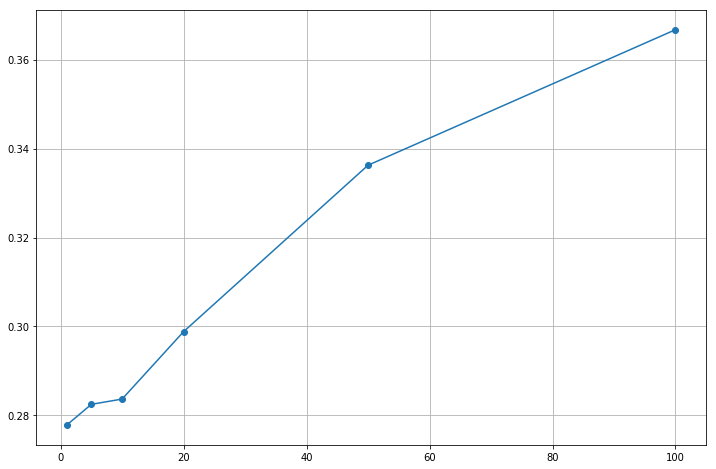

In [103]:
plt.figure(figsize=(12, 8))
plt.plot(estim_grid, quality, marker='o')
plt.grid()
plt.show()

In [120]:
print(model)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=250,
       n_jobs=7, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=7, seed=None,
       silent=True, subsample=1)


In [127]:
# make predictions for test data
y_pred = model.predict(X_test)
# y_pred
predictions = [round(value) for value in y_pred]

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [128]:
predictions

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


In [129]:
print('rec:', recall_score(y_test, predictions))
print('pre:', precision_score(y_test, predictions))
print(' f1:', f1_score(y_test, predictions))

NameError: name 'y_test' is not defined

# RFC

In [178]:
from sklearn import ensemble
from sklearn import ensemble, cross_validation, learning_curve, metrics 
from sklearn.model_selection import cross_val_score

In [172]:
rf_classifier = ensemble.RandomForestClassifier(n_estimators=10, max_depth = 30, verbose=True)

In [176]:
rf_classifier.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   14.0s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=30, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=True,
            warm_start=False)

In [180]:
scores = cross_val_score(rf_classifier, X_train, y_train, cv=3, scoring='f1')
scores

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.8s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    8.2s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    8.4s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished


array([0.0288635 , 0.01451735, 0.0150485 ])

In [174]:
train_sizes, train_scores, test_scores = learning_curve.learning_curve(rf_classifier, X_train, y_train, 
                                                                       train_sizes=np.arange(0.1,1, 0.2), 
                                                                       cv=3, scoring='f1', verbose=True)

[learning_curve] Training set sizes: [ 15864  47593  79322 111051 142780]


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.2s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]

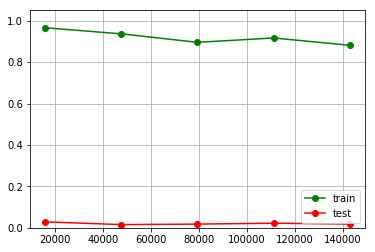

In [175]:
pylab.grid(True)
pylab.plot(train_sizes, train_scores.mean(axis = 1), 'g-', marker='o', label='train')
pylab.plot(train_sizes, test_scores.mean(axis = 1), 'r-', marker='o', label='test')
pylab.ylim((0.0, 1.05))
pylab.legend(loc='lower right')

In [166]:
# print(sorted(list(rf_classifier.feature_importances_)))
print(y_train)

0         0
1         0
2         0
3         0
4         0
5         0
6         0
7         0
8         0
9         0
10        0
11        0
12        0
13        0
14        0
15        0
16        0
17        0
18        0
19        0
20        0
21        0
22        0
23        0
24        0
25        0
26        0
27        0
28        0
29        0
         ..
237939    0
237940    0
237941    0
237942    0
237943    0
237944    0
237945    0
237946    0
237947    0
237948    0
237949    0
237950    0
237951    0
237952    0
237953    0
237954    0
237955    0
237956    0
237957    0
237958    1
237959    0
237960    1
237961    1
237962    1
237963    1
237964    1
237965    0
237966    0
237967    0
237968    0
Name: mg, Length: 237969, dtype: int64


In [167]:
y_pred = rf_classifier.predict(X_test)

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


In [169]:
y_pred


array([0, 0, 0, ..., 0, 0, 0])

In [130]:
def write_ans(preds):
    answer = pd.DataFrame({'mg': preds})
    answer['Id'] = np.arange(answer.shape[0])
    answer.to_csv('ans.csv', index=False)

In [131]:
write_ans(predictions)

# Data Processing Guide

In [3]:
import sys
sys.path.insert(0, 'basic_codes')

import class_magnesium_not_drop_na #_transform_pairings
from class_magnesium_not_drop_na import *
from sklearn.ensemble import AdaBoostClassifier

In [4]:
file_train = 'train.csv'
file_test = 'test.csv'
fold = './'

In [5]:
import importlib
importlib.reload(class_magnesium_not_drop_na)
from class_magnesium_not_drop_na import *

In [ ]:
'''
    Класс Magnesium загружает данные из файла file_, находящегося в папке fold. 
    Делает dropna (чтобы кас не ругался)
    
    model - модель, с которой вы хотите работать, по умолчанию RFC
    Сохраняет переменные:
    data - загруженный DataFrame
    features - признаки
    groups - цепочки
    x - данные для бучения в виде Numpy-матрицы
    y - целевой признак
'''
m = Magnesium(file_train, fold = fold, model=AdaBoostClassifier(base_estimator=None, n_estimators=400, learning_rate=0.8))

Data processing...

In [ ]:
def load_data(filename):
    '''
        Функция для загрузки датасета без инициализации класса. 
        
        Возвращает:
         data - полный DataFrame
         fetures - список признаков для обучения/предсказания
         x - датасет для тренировки/предсказания в формате np.array
         y - целевой признак, если он есть. В случае с тестовым датасетом возвращает None
    '''
    
    data = pd.read_table(filename, sep=',').dropna()    
    
    data = data[~(data['chainlen']>1000)]

    if ('DSSR' in data.columns):
        data.drop('DSSR', axis=1, inplace=True)    
    
    features = list(deepcopy(data.columns))
    [features.remove(column) for column in ['Id','index', 'pdb_chain', 'mg'] if column in data.columns];
    x_test = np.array(data[features])
    
    try:
        y_test = np.array(data['mg'])
    except: 
        y_test = None
    change_output('Data loaded')
    return {'data':data, 'features':features, 'x':x_test, 'y':y_test}

In [ ]:
test = load_data(fold+file_test)

In [ ]:
m.trained_model = deepcopy(m.model)
m.trained_model.fit(m.x, m.y)